# Temporal hierarchy in Recurrent dynamics
---
Here we look for the fingerprint of temporal hierarchy in recurrent dynamics. 

The core idea is that the "speed" of a population of recurrently neurons is related to the eigenvalues of the recurrent matrix.

Starting from a simple first order differential equation we have:
$ \tau \frac{ \delta v(t) }{ \delta t } = - v(t) $

where $\tau$ is the time constant, $v(t)$ can represent the neurons membrane voltage.

When such neurons are recurrently connected:
$ \tau \frac{ \delta v(t) }{ \delta t } = - v(t) + W_{rec} v(t) $

where $W_{rec}$ is the recurrent matrix.

we can rewrite that in this form:
$ \frac{ \delta v(t) }{ \delta t } = W'_{rec} v(t) $
where $W'_{rec} = (W_{rec} - I)/ \tau$ and $I$ the identity matrix.

We can project the membrane voltage to the eigenvector space:
$ W \frac{ \delta v(t) }{ \delta t } = \lambda u v(t) = \lambda v'(t) $
with $v' = u v$.

Then:
$ \frac{ \delta v'(t) }{ \delta t } = \lambda v'(t) $

From this equation we highlight the role of the eigenvalue $\lambda$ as the time constant in the eigenvector space:
$ 1/\lambda \approx \tau_u $

---

If the concept of temporal hierarchy holds for recurrent SNNs, then the recurrent matrix's eigenvalues should be ordered in a particular manner through the hidden layers of the network. Let's see :)

In [2]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

I0000 00:00:1725261011.001937       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
from models import *
from utils_initialization import *
from training import *

### RSNN on SHD
---

In [73]:
seeds = [0,1,2,3,4,5,6,7,8,9]
params_networks = []

# setting some hyper-params
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = 'uniform'
args.recurrent = True
args.normalizer = 'batch' # 'batch' #'layer'
args.n_layers = 4
args.n_hid = 128
# time constants
args.tau_mem = 0.1 #0.1
args.delta_tau = 0.075

# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 10
args.decoder = 'cum'
args.dataset_name = 'shd'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels

for s, seed in enumerate( seeds ):
    args.seed = seed

    # saving the model in the following directory
    args.save_dir_name = f'Recurrent_dynamics_analysis/hRSNN_Layers{args.n_layers}_Hid{args.n_hid}'

    # Training
    train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args, wandb_flag=False )

Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Epoch: [1/10] - Loss: 1.96920 -  Training acc: 39.56 - Validation acc: 68.82 - t: 13.63 sec
Epoch: [2/10] - Loss: 0.79539 -  Training acc: 77.31 - Validation acc: 84.78 - t: 7.31 sec
Epoch: [3/10] - Loss: 0.47263 -  Training acc: 86.83 - Validation acc: 89.03 - t: 7.13 sec
Epoch: [4/10] - Loss: 0.33203 -  Training acc: 90.77 - Validation acc: 92.02 - t: 7.25 sec
Epoch: [5/10] - Loss: 0.25621 -  Training acc: 92.73 - Validation acc: 93.56 - t: 7.32 sec
Epoch: [6/10] - Loss: 0.20106 -  Training acc: 94.82 - Validation acc: 94.12 - t: 7.15 sec
Epoch: [7/10] - Loss: 0.17960 -  Training acc: 95.22 - Validation acc: 94.70 - t: 7.31 sec
Epoch: [8/10] - Loss: 0.16399 -  Training acc: 95.37 - Validation acc: 94.22 - t: 7.43 sec
Epoch: [9/10] - Loss: 0.13245 -  Training acc: 96.64 - Validation acc: 95.83 - t: 7.39 sec
Epoch: [10/10] - Loss: 0.12692 -  Training acc: 96.81 - Validation acc: 95.24 - t: 7.27 sec
Validation Accuracy: 9

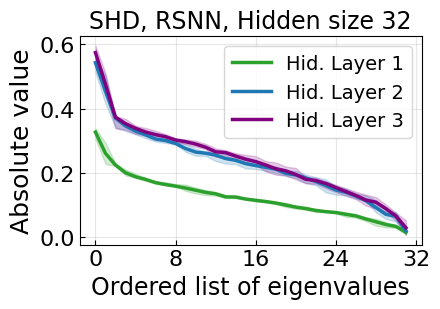

In [32]:
seeds = [0,1,2,3,4,5,6,7,8,9]
dir_results     = '/Users/filippomoro/Documents/hsnn/results/Recurrent_dynamics_analysis'
file_name       = 'hRSNN_Layers{}_Hid{}_seed{}/model.pkl'
num_layers      = 4
n_hid           = 32

# net_params_list  = []
eigenvalues_list = np.zeros( (len(seeds), num_layers-1, n_hid) )

for s, seed in enumerate(seeds):
    model = pickle.load( open( os.path.join( dir_results, file_name.format( num_layers, n_hid, seed ) ), 'rb' ) )
    # net_params_best.append( model['net_params_best'] )
    # net_params_list.append( net_params_best )

    # collecting the eigenvalues in all layers, for all trained models
    # eigenvalues_list.append( [ jnp.absolute( jnp.linalg.eig( net_params_best[i][0][0][1] )[0] ) for i in range(num_layers-1) ] )
    eigenvalues_list[s] = np.sort( [ jnp.absolute( jnp.linalg.eig( model['net_params_best'][i][0][0][1] )[0] ) for i in range(num_layers-1) ] )[:,np.arange(n_hid-1, -1, -1) ]
# eigenvalues_list = np.stack( eigenvalues_list )

# plotting the eigenvalues
fig, ax = plt.subplots( figsize=(4.5,3.2) )
eigenvalues_list_mean = np.mean( eigenvalues_list, axis=0 )
eigenvalues_list_qmin = np.quantile( eigenvalues_list, axis=0, q=0.25 )
eigenvalues_list_qmax = np.quantile( eigenvalues_list, axis=0, q=0.75 )
colors = ['tab:green', 'tab:blue', 'purple', 'orange']
for i in range(num_layers-1):
    ax.plot( eigenvalues_list_mean[i], label=f'Hid. Layer {i+1}', color=colors[i], lw=2.5 )
    ax.fill_between( np.arange( n_hid ), eigenvalues_list_qmin[i], eigenvalues_list_qmax[i], color=colors[i], alpha=0.2 )
ax.set_ylabel('Absolute value', size=18)
ax.set_xlabel('Ordered list of eigenvalues', size=17)
ax.tick_params( direction='in', labelsize=16 )
ax.legend(prop={'size':14}, loc=0)
ax.set_xticks( np.arange( 0, n_hid+1, n_hid/4 ) )
ax.grid(alpha=0.3)
ax.set_title( 'SHD, RSNN, Hidden size {}'.format( n_hid ), size=17 )

plt.tight_layout()
fig.savefig( '/Users/filippomoro/Documents/hsnn/results/FS6/hRSNN_Layers{}_Hid{}.pdf'.format( num_layers, n_hid ), dpi=300, transparent=True )

### RSNN on MST-XOR
---

In [27]:
seeds = [0,1,2,3,4,5,6,7,8,9]
params_networks = []

# setting some hyper-params
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = 'uniform'
args.recurrent = True
args.normalizer = 'batch' # 'batch'
args.n_layers = 4
args.n_hid = 10
# time constants
args.tau_mem = 0.3
args.delta_tau = 0.0

# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 20
# task-specific parameters
args.dataset_name = 'mts_xor'
args.n_in = 40
args.n_out = 2
args.decoder = 'vmem_time'
args.time_max = 1.0 # second
args.timestep = args.time_max/args.nb_steps # second
args.tau_out = 0.05
args.distrib_tau_sd = 0.1
args.batch_size = 512

for s, seed in enumerate( seeds ):
    args.seed = seed

    # saving the model in the following directory
    args.save_dir_name = f'Recurrent_dynamics_analysis/hRSNN_MTSXOR_Layers{args.n_layers}_Hid{args.n_hid}'

    # Training
    train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args, wandb_flag=False )

Epoch: [1/20] - Loss: 0.73427 -  Training acc: 52.13 - Validation acc: 52.08 - t: 5.48 sec
Epoch: [2/20] - Loss: 0.69607 -  Training acc: 55.68 - Validation acc: 53.36 - t: 0.91 sec
Epoch: [3/20] - Loss: 0.69126 -  Training acc: 56.93 - Validation acc: 55.32 - t: 0.91 sec
Epoch: [4/20] - Loss: 0.68574 -  Training acc: 58.18 - Validation acc: 57.01 - t: 0.90 sec
Epoch: [5/20] - Loss: 0.68119 -  Training acc: 58.83 - Validation acc: 58.55 - t: 0.90 sec
Epoch: [6/20] - Loss: 0.67634 -  Training acc: 59.57 - Validation acc: 59.82 - t: 0.90 sec
Epoch: [7/20] - Loss: 0.67004 -  Training acc: 60.47 - Validation acc: 62.56 - t: 0.90 sec
Epoch: [8/20] - Loss: 0.66023 -  Training acc: 62.11 - Validation acc: 66.19 - t: 0.90 sec
Epoch: [9/20] - Loss: 0.64966 -  Training acc: 64.03 - Validation acc: 69.65 - t: 0.91 sec
Epoch: [10/20] - Loss: 0.63790 -  Training acc: 65.65 - Validation acc: 73.38 - t: 0.90 sec
Epoch: [11/20] - Loss: 0.62399 -  Training acc: 67.35 - Validation acc: 76.27 - t: 0.90 s

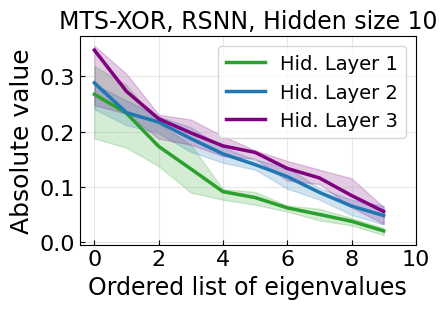

In [31]:
seeds = [0,1,2,3,4,5,6,7,8,9]
# dir_results     = '/Users/filippomoro/Documents/hsnn/results/Recurrent_dynamics_analysis'
dir_results     = os.getcwd() + '/results/Recurrent_dynamics_analysis'
file_name       = 'hRSNN_MTSXOR_Layers{}_Hid{}_seed{}/model.pkl'
num_layers      = 4
n_hid           = 10

# net_params_list  = []
eigenvalues_list = np.zeros( (len(seeds), num_layers-1, n_hid) )

for s, seed in enumerate(seeds):
    model = pickle.load( open( os.path.join( dir_results, file_name.format( num_layers, n_hid, seed ) ), 'rb' ) )
    # net_params_best.append( model['net_params_best'] )
    # net_params_list.append( net_params_best )

    # collecting the eigenvalues in all layers, for all trained models
    # eigenvalues_list.append( [ jnp.absolute( jnp.linalg.eig( net_params_best[i][0][0][1] )[0] ) for i in range(num_layers-1) ] )
    eigenvalues_list[s] = np.sort( [ jnp.absolute( jnp.linalg.eig( model['net_params_best'][i][0][0][1] )[0] ) for i in range(num_layers-1) ] )[:,np.arange(n_hid-1, -1, -1) ]
# eigenvalues_list = np.stack( eigenvalues_list )

# plotting the eigenvalues
fig, ax = plt.subplots( figsize=(4.5,3.2) )
eigenvalues_list_mean = np.mean( eigenvalues_list, axis=0 )
eigenvalues_list_qmin = np.quantile( eigenvalues_list, axis=0, q=0.25 )
eigenvalues_list_qmax = np.quantile( eigenvalues_list, axis=0, q=0.75 )
colors = ['tab:green', 'tab:blue', 'purple', 'orange']
for i in range(num_layers-1):
    ax.plot( eigenvalues_list_mean[i], label=f'Hid. Layer {i+1}', color=colors[i], lw=2.5 )
    ax.fill_between( np.arange( n_hid ), eigenvalues_list_qmin[i], eigenvalues_list_qmax[i], color=colors[i], alpha=0.2 )
ax.set_ylabel('Absolute value', size=18)
ax.set_xlabel('Ordered list of eigenvalues', size=17)
ax.tick_params( direction='in', labelsize=16 )
ax.legend(prop={'size':14}, loc=0)
ax.set_xticks( np.arange( 0, n_hid+1, n_hid/5 ) )
ax.grid(alpha=0.3)
ax.set_title( 'MTS-XOR, RSNN, Hidden size {}'.format( n_hid ), size=17 )

plt.tight_layout()
fig.savefig( '/Users/filippomoro/Documents/hsnn/results/FS6/hRSNN_MTSXOR_Layers{}_Hid{}.pdf'.format( num_layers, n_hid ), dpi=300, transparent=True )